### Initial setup

In [1]:
# Import libraries
import pandas as pd
import numpy as np
from patsy import dmatrices, dmatrix
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import theano
import theano.tensor as tt
import pymc3 as pm
import arviz as az

import warnings
warnings.simplefilter(action="ignore")

print("Packages uploaded successfully!")

Packages uploaded successfully!


### Data preparation

In [2]:
# Read data
data = pd.read_csv('./machine_readable_dnt.csv')

In [3]:
# Standardise continuous values
data_prep = data[['SLogP', 'Cbrain/Cblood','Syn_EC30', 
                  'Viability_EC30', 'NNF EC50min', 'NNF EC50max', 'Viability_LDH']]
sc = StandardScaler()
data_scaled = sc.fit_transform(data_prep)
data_scaled = pd.DataFrame(data_scaled)
data_scaled.columns = ['SLogP', 'Cbrain/Cblood','Syn_EC30', 
                       'Viability_EC30', 'NNF EC50min', 'NNF EC50max', 'Viability_LDH']

#Add other discrete values and details
discrete = data [['ID', 'Chemical', 'CASRN', 'DNT', 'BBB', 'Pgp_inhibition', 'Pgp_substrate', 'Pgp_active', 
  'BDNF, Reduction', 'Activity_Syn', 'Activity_NNF']]
data = discrete.join(data_scaled, lsuffix="_left", rsuffix="_right")

In [4]:
# Define predictors and outcomes

#BDNF given by continuous and discrete variables
x_bdnf_continue = pd.DataFrame(data[['SLogP', 'Cbrain/Cblood']]).values
x_bdnf_binary = pd.DataFrame(data[['BBB', 'Pgp_inhibition', 'Pgp_substrate', 'Pgp_active']]).values
y_bdnf = pd.DataFrame(data[['BDNF, Reduction']]).values

#Syn
x_syn = pd.DataFrame(data[['Syn_EC30', 'Viability_EC30']]).values
Y_syn = pd.DataFrame(data[['Activity_Syn']]).values #Y because no missing values

#NNF
x_nnf = pd.DataFrame(data[['NNF EC50min', 'NNF EC50max', 'Viability_LDH']]).values
Y_nnf = pd.DataFrame(data[['Activity_NNF']]).values #Y because no missing values

#x_dnt is given by causal relations BDNF->SYN->NNF->DNT<-BNDF
Y_dnt = pd.DataFrame(data[['DNT']]).values #Y because no missing values

### Strategy: Imputation by distribution

In [5]:
# Mask missing values

#BDNF
x_bdnf_missing_continue = np.isnan(x_bdnf_continue)
x_bdnf_missing_binary = np.isnan(x_bdnf_binary)
X_bdnf_train_continue = np.ma.masked_array(x_bdnf_continue, mask=x_bdnf_missing_continue)
X_bdnf_train_binary = np.ma.masked_array(x_bdnf_binary, mask=x_bdnf_missing_binary)
y_bdnf_missing = np.isnan(y_bdnf)
Y_bdnf_train = np.ma.masked_array(y_bdnf, mask=y_bdnf_missing)

#Syn
x_syn_missing = np.isnan(x_syn)
X_syn_train = np.ma.masked_array(x_syn, mask=x_syn_missing)
y_syn_missing = np.isnan(Y_syn)
Y_syn_train = np.ma.masked_array(Y_syn, mask=y_syn_missing)

#NNF
x_nnf_missing = np.isnan(x_nnf)
X_nnf_train = np.ma.masked_array(x_nnf, mask=x_nnf_missing)
y_nnf_missing = np.isnan(Y_nnf)
Y_nnf_train = np.ma.masked_array(Y_nnf, mask=y_nnf_missing)

#DNT
y_dnt_missing = np.isnan(Y_dnt)
Y_dnt_train = np.ma.masked_array(Y_dnt, mask=y_dnt_missing)

### Define and fit the model

In [6]:
with pm.Model() as model_hierar:
    #Define hyperpriors
    mu_beta = pm.Normal('mu_beta', mu=0, sd=0.01) 
    sd_beta = pm.HalfNormal('sd_beta', sd=5)
    #Define priors
    beta_bdnf_continue = pm.Normal('beta_bdnf_continue', mu=mu_beta, sd=sd_beta, shape=(2,1))
    beta_bdnf_binary = pm.Normal('beta_bdnf_binary', mu=mu_beta, sd=sd_beta, shape=(4,1))
    beta_syn = pm.Normal('beta_syn', mu=mu_beta, sd=sd_beta, shape=(2,1))
    beta_nnf = pm.Normal('beta_nnf', mu=mu_beta, sd=sd_beta, shape=(3,1))

In [7]:
# ## Define BDNF
with model_hierar:
    # Imputation of X missing values for BDNF
    Xmu_bdnf_continue = pm.Normal('Xmu_bdnf_continue', mu=0, sd=0.01, shape=(1,2))
    Xsigma_bdnf_continue = pm.HalfNormal('Xsigma_bdnf_continue', sd=5, shape=(1,2))
    X_bdnf_modelled_continue = pm.Normal('X_bdnf_modelled_continue', 
                                         mu=Xmu_bdnf_continue, sd=Xsigma_bdnf_continue, 
                                         observed=X_bdnf_train_continue)
    p = pm.Beta('p', alpha=2, beta=2)
    X_bdnf_modelled_binary = pm.Bernoulli('X_bdnf_modelled_binary', 
                                         p=p, observed=X_bdnf_train_binary)
    

    # Likelihood for BDNF
    #SLogP, Cbrain/Cblood, BBB, Pgp->BDNF
    lp_bdnf = pm.Deterministic('lp_bdnf', pm.math.dot(X_bdnf_modelled_continue, beta_bdnf_continue) +
                              pm.math.dot(X_bdnf_modelled_binary, beta_bdnf_binary)) 
    y_obs_bdnf = pm.Bernoulli('y_obs_bdnf', logit_p=lp_bdnf, observed=Y_bdnf_train)

In [8]:
# ## Define SYN
with model_hierar:
    # Imputation of X missing values for Syn
    Xmu_syn = pm.Normal('Xmu_syn', mu=0, sd=0.01, shape=(1,2))
    Xsigma_syn = pm.HalfNormal('Xsigma_syn', sd=5, shape=(1,2))
    X_syn_modelled = pm.Normal('X_syn_modelled', mu=Xmu_syn, sd=Xsigma_syn, observed=X_syn_train)
   
    # Likelihood for Syn
    #BDNF->SYN
    lp_syn =  pm.Deterministic('lp_syn', lp_bdnf + pm.math.dot(X_syn_modelled, beta_syn))    
    y_obs_syn = pm.Bernoulli("y_obs_syn", logit_p = lp_syn, observed=Y_syn_train)

In [9]:
# ## Define NNF
with model_hierar:
    # Imputation of X missing values for NNF
    Xmu_nnf = pm.Normal('Xmu_nnf', mu=0, sd=0.01, shape=(1,3))
    Xsigma_nnf = pm.HalfNormal('Xsigma_nnf', sd=5, shape=(1,3)) 
    X_nnf_modelled = pm.Normal('X_nnf_modelled', mu=Xmu_nnf, sd=Xsigma_nnf, observed=X_nnf_train)
   
    # Likelihood for NNF
    #BDNF->SYN->NNF
    lp_nnf = pm.Deterministic('lp_nnf', lp_syn + pm.math.dot(X_nnf_modelled, beta_nnf))
    y_obs_nnf = pm.Bernoulli("y_obs_nnf", logit_p=lp_nnf, observed=Y_nnf_train)

In [10]:
# ## Define DNT
with model_hierar:
    #Define causal relationships for DNT
    lp_dnt = pm.Deterministic('lp_dnt', lp_bdnf + lp_syn + lp_nnf)
    y_obs_dnt = pm.Bernoulli('y_obs_dnt', logit_p=lp_dnt, observed=Y_dnt_train)

In [11]:
# ## Checking the proposed structure of model
model_hierar.check_test_point()

mu_beta                               3.69
sd_beta_log__                        -0.77
beta_bdnf_continue                   -4.61
beta_bdnf_binary                     -9.21
beta_syn                             -4.61
beta_nnf                             -6.91
Xmu_bdnf_continue                     7.37
Xsigma_bdnf_continue_log__           -1.54
X_bdnf_modelled_continue_missing      0.00
p_logodds__                          -0.98
X_bdnf_modelled_binary_missing        0.00
y_obs_bdnf_missing                    0.00
Xmu_syn                               7.37
Xsigma_syn_log__                     -1.54
X_syn_modelled_missing                0.00
Xmu_nnf                              11.06
Xsigma_nnf_log__                     -2.31
X_nnf_modelled_missing                0.00
X_bdnf_modelled_continue           -452.42
X_bdnf_modelled_binary             -268.94
y_obs_bdnf                          -67.24
X_syn_modelled                     -450.91
y_obs_syn                           -67.24
X_nnf_model

In [12]:
# ## Run inferences
with model_hierar:
    trace_hierar = pm.sample(cores=4, return_inferencedata=True) #, nuts ={'target_accept':0.90})

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [X_nnf_modelled_missing, Xsigma_nnf, Xmu_nnf, X_syn_modelled_missing, Xsigma_syn, Xmu_syn, p, X_bdnf_modelled_continue_missing, Xsigma_bdnf_continue, Xmu_bdnf_continue, beta_nnf, beta_syn, beta_bdnf_binary, beta_bdnf_continue, sd_beta, mu_beta]
>BinaryGibbsMetropolis: [X_bdnf_modelled_binary_missing, y_obs_bdnf_missing]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 84 seconds.


In [13]:
# ## Compute prior and posterior distributions
with model_hierar:
    #prior_all_hierar = pm.sample_prior_predictive(1000) #ERROR
    posterior_all_hierar = pm.sample_posterior_predictive(trace_hierar)

### Check convergence

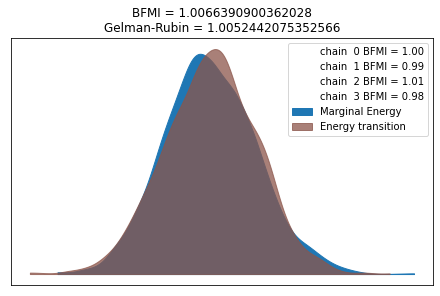

In [14]:
# Check the energy plot
bfmi = np.max(pm.stats.bfmi(trace_hierar))
max_gr = max(np.max(gr_stats) for gr_stats in pm.stats.rhat(trace_hierar).values()).values
(pm.energyplot(trace_hierar, legend=True, figsize=(6, 4))
   .set_title("BFMI = {}\nGelman-Rubin = {}".format(bfmi, max_gr)));

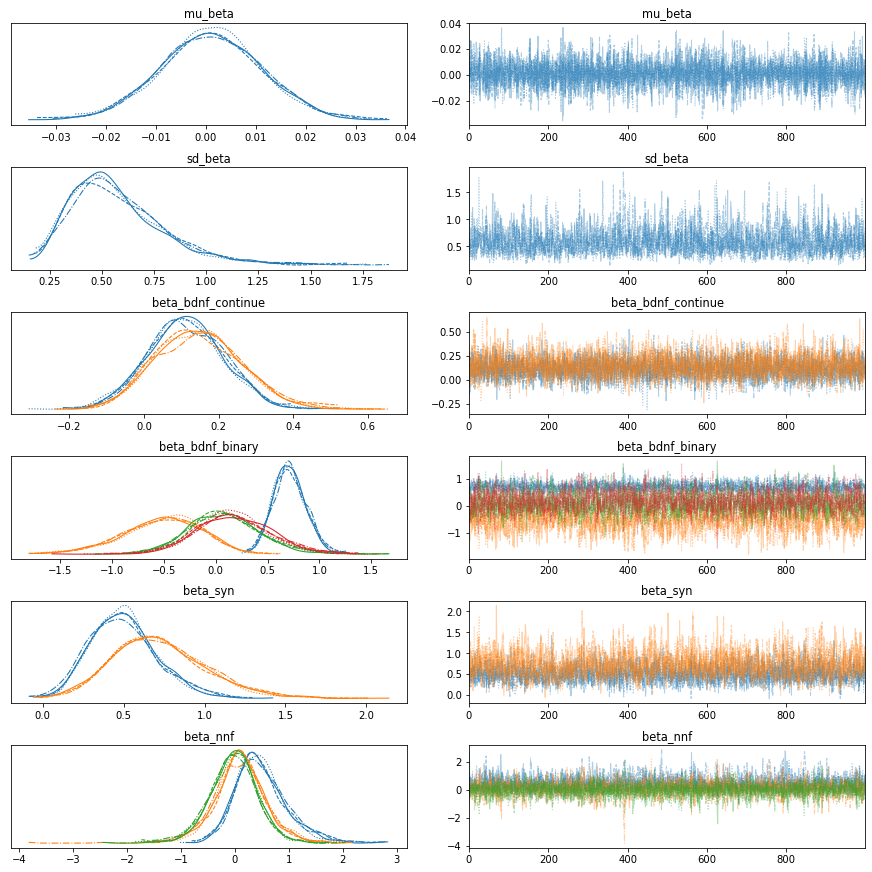

In [15]:
# Check hyperpriors and priors
pm.traceplot(trace_hierar, var_names=['mu_beta', 'sd_beta', 'beta_bdnf_continue',
                                      'beta_bdnf_binary', 'beta_syn', 'beta_nnf']);

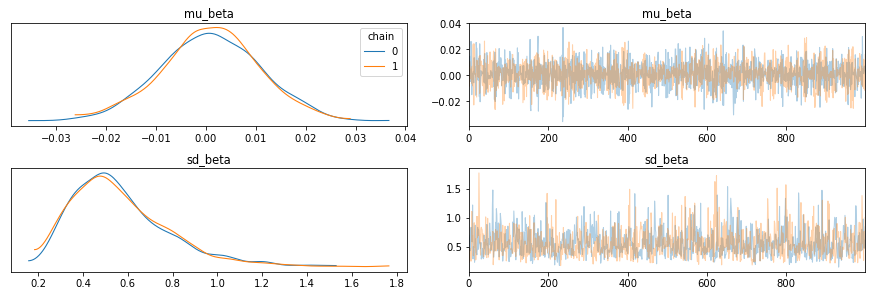

In [16]:
#Check convergence for hyperpriors of two chains
az.plot_trace(trace_hierar, var_names=['mu_beta', 'sd_beta'],
             coords={"chain":[0,1]}, legend=True)
#plt.suptitle("Trace plots")
plt.show()

In [17]:
# Statistical summary
az.summary(trace_hierar)

#Save the statistical summary of the trace
#file = az.summary(trace, round_to=None)
#file.to_csv('Statistical_summary_trace.csv')

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mu_beta,0.001,0.010,-0.018,0.021,0.000,0.000,8650.0,1607.0,8676.0,3076.0,1.0
"beta_bdnf_continue[0,0]",0.112,0.103,-0.073,0.310,0.002,0.001,3671.0,2883.0,3711.0,3206.0,1.0
"beta_bdnf_continue[1,0]",0.148,0.118,-0.067,0.366,0.002,0.002,3737.0,2850.0,3892.0,2996.0,1.0
"beta_bdnf_binary[0,0]",0.714,0.157,0.426,1.000,0.004,0.003,1936.0,1917.0,1954.0,2492.0,1.0
"beta_bdnf_binary[1,0]",-0.517,0.376,-1.255,0.138,0.010,0.007,1354.0,1354.0,1370.0,2050.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
"lp_dnt[92,0]",-0.048,1.495,-2.821,2.792,0.022,0.019,4800.0,3139.0,4787.0,3962.0,1.0
"lp_dnt[93,0]",-1.348,1.705,-4.528,1.757,0.028,0.021,3786.0,3242.0,3952.0,3410.0,1.0
"lp_dnt[94,0]",-0.057,1.502,-2.807,2.798,0.021,0.018,4892.0,3339.0,4934.0,3655.0,1.0
"lp_dnt[95,0]",-0.068,1.513,-3.086,2.668,0.021,0.019,5269.0,3056.0,5260.0,3705.0,1.0


In [18]:
#Helper functions
def convergence_hist(hist_data):
    fig, ax = plt.subplots(figsize=(6, 6))
    plt.hist(hist_data, bins=50, color="#1f77b4", ec="#3d5167", alpha=0.9, lw=1.2)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.yticks(ticks=None)

    return fig, ax

#R-hat
def check_rhat(inf_data, threshold=1.1, verbose=True):
    s = az.summary(inf_data, round_to="none")
    fig, ax = convergence_hist(s["r_hat"])
    #ax.set_xlabel("Rhat statistic", labelpad=15)
    ax.set_title("$\hat{R}$")

    bad = s[s["r_hat"] > threshold]
    if len(bad) == 0:
        text = "None"
    else:
        text = list(bad.index)
        ax.axvline(x=threshold, c="#3d5167", lw=2)
    if verbose:
        print(f"The following parameters have an Rhat greater {threshold}:\n{text}\n")
    return fig, ax

#MCSE
def check_mcse(inf_data, threshold=0.1, verbose=True):
    s = az.summary(inf_data, round_to="none")
    hist_data = s["mcse_mean"] / s["sd"]
    fig, ax = convergence_hist(hist_data)
    #ax.set_xlabel("Monte Carlo standard error / posterior sd", labelpad=15)
    ax.set_title("Monte Carlo Standard Error/Posterior sd")
    ax.locator_params(axis='x', nbins=5)

    bad = s[hist_data > threshold]
    if len(bad) == 0:
        text = "None"
    else:
        text = list(bad.index)
        ax.axvline(x=threshold, c="#3d5167", lw=2)
    if verbose:
        print(
            f"The following parameters have a Monte Carlo standard error greater than {threshold * 100}% of the posterior standard deviation:\n{text}\n")
    return fig, ax

#ESS/NEFF, number of effective sample size
def check_neff(inf_data, threshold=0.1, verbose=True):
    N = inf_data.posterior.dims['chain'] * inf_data.posterior.dims['draw']
    s = az.summary(inf_data, round_to="none")
    fig, ax = convergence_hist(s["ess_mean"] / N)
    #ax.set_xlabel("Effective sample size / iterations", labelpad=15)
    ax.set_title("$n_{eff}/N$")

    bad = s[s["ess_mean"] / N < threshold]
    if len(bad) == 0:
        text = "None"
    else:
        text = list(bad.index)
        ax.axvline(x=threshold, c="#3d5167", lw=2)
    if verbose:
        print(
            f"The following parameters have an effective sample size less than {threshold * 100}% of the total sample size:\n{text}\n")
    return fig, ax

The following parameters have an Rhat greater 1.05:
None

The following parameters have a Monte Carlo standard error greater than 10.0% of the posterior standard deviation:
None

The following parameters have an effective sample size less than 10.0% of the total sample size:
None



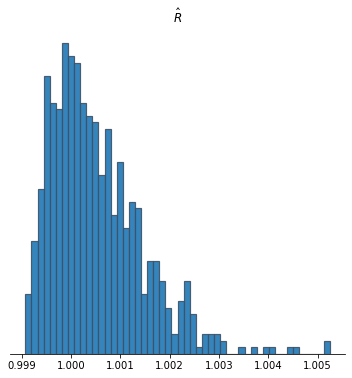

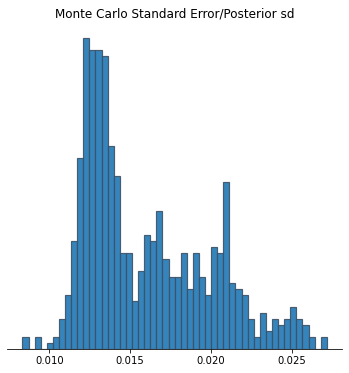

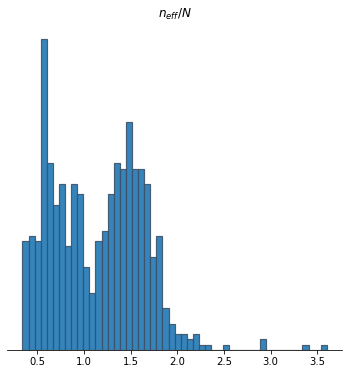

In [19]:
# Plot statistical summary of convergences
check_rhat(trace_hierar, threshold=1.05); #1.005 also considered
check_mcse(trace_hierar);
check_neff(trace_hierar);

### Check goodness of fit

In [ ]:
###ERROR
# Convert to Arviz
idata = az.from_pymc3(trace_hierar, 
                      posterior_predictive=posterior_all_hierar, 
                      model = model_hierar)

In [ ]:
#ERROR
# Plot observed vs posterior predictive vs posterior mean
az.plot_ppc(idata); #kind='density'

In [ ]:
#ERROR
# Plot posterior of compounds
pm.plot_posterior(posterior_all_hierar, var_names=['lp_bdnf', 'lp_syn', 'lp_nnf', 'lp_dnt']);

In [ ]:
###Can I switch with posterior_all_hierar and get similar to trace?
# Plot traces each compound
pm.forestplot(trace_hierar, var_names='lp_bdnf'); 
pm.forestplot(trace_hierar, var_names='lp_syn');
pm.forestplot(trace_hierar, var_names='lp_nnf');
pm.forestplot(trace_hierar, var_names='lp_dnt');

In [ ]:
###ERROR
# Compare prior with posterior
sns.distplot(prior['beta_bdnf'], label='Prior', hist=False)
ax = sns.distplot(trace.posterior['beta_bdnf'], label='Posterior', hist=False)
ax.legend();

### Strategy: Imputation by mean

In [20]:
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')

#BDNF
X_bdnf_meanimpute_continue = imp_mean.fit_transform(x_bdnf_continue)
X_bdnf_meanimpute_binary = imp_mean.fit_transform(x_bdnf_binary)
Y_bdnf_meanimpute = imp_mean.fit_transform(y_bdnf)

#Syn
X_syn_meanimpute = imp_mean.fit_transform(x_syn)

#NNF
X_nnf_meanimpute = imp_mean.fit_transform(x_nnf)

In [21]:
with pm.Model() as model_meanimput:
    #Define hyperpriors
    mu_beta_meanimput = pm.Normal('mu_beta_meanimput', mu=0, sd=0.01) 
    sd_beta_meanimput = pm.HalfNormal('sd_beta_meanimput', sd=5)
    #Define priors
    beta_bdnf_meanimput_continue = pm.Normal('beta_bdnf_meanimput_continue', 
                                             mu=mu_beta_meanimput, sd=sd_beta_meanimput, shape=(2,1))
    beta_bdnf_meanimput_binary = pm.Normal('beta_bdnf_meanimput_binary', 
                                           mu=mu_beta_meanimput, sd=sd_beta_meanimput, shape=(4,1))
    beta_syn_meanimput = pm.Normal('beta_syn_meanimput', mu=mu_beta_meanimput, sd=sd_beta_meanimput, shape=(2,1))
    beta_nnf_meanimput = pm.Normal('beta_nnf_meanimput', mu=mu_beta_meanimput, sd=sd_beta_meanimput, shape=(3,1))

In [22]:
# ## Define BDNF 
with model_meanimput:
    # Likelihood for BDNF
    #SLogP, Cbrain/Cblood, BBB, Pgp->BDNF
    lp_bdnf_meanimput = pm.Deterministic('lp_bdnf_meanimput', pm.math.dot(X_bdnf_meanimpute_continue, 
                                                                          beta_bdnf_meanimput_continue) +
                                        pm.math.dot(X_bdnf_meanimpute_binary, beta_bdnf_meanimput_binary)) 
    y_obs_bdnf_meanimput = pm.Bernoulli('y_obs_bdnf_meanimput', logit_p=lp_bdnf_meanimput, observed=Y_bdnf_meanimpute)

In [23]:
# ## Define SYN
with model_meanimput:   
    # Likelihood for Syn
    #BDNF->SYN
    lp_syn_meanimput =  pm.Deterministic('lp_syn_meanimput', 
                                         lp_bdnf_meanimput + pm.math.dot(X_syn_meanimpute, beta_syn_meanimput))    
    y_obs_syn_meanimput = pm.Bernoulli("y_obs_syn_meanimput", 
                                       logit_p = lp_syn_meanimput, observed=Y_syn)

In [24]:
# ## Define NNF
with model_meanimput:
    # Likelihood for NNF
    #BDNF->SYN->NNF
    lp_nnf_meanimput = pm.Deterministic('lp_nnf_meanimput', 
                                        lp_syn_meanimput + pm.math.dot(X_nnf_meanimpute, beta_nnf_meanimput))
    y_obs_nnf_meanimput = pm.Bernoulli("y_obs_nnf_meanimput", logit_p=lp_nnf_meanimput, observed=Y_nnf)

In [25]:
# ## Define DNT
with model_meanimput:
    #Define causal relationships for DNT
    lp_dnt_meanimput = pm.Deterministic('lp_dnt_meanimput', 
                                        lp_bdnf_meanimput + lp_syn_meanimput + lp_nnf_meanimput)
    y_obs_dnt_meanimput = pm.Bernoulli('y_obs_dnt_meanimput', 
                                       logit_p=lp_dnt_meanimput, observed=Y_dnt)

In [26]:
# Checking the proposed structure of model
model_meanimput.check_test_point()

mu_beta_meanimput                3.69
sd_beta_meanimput_log__         -0.77
beta_bdnf_meanimput_continue    -4.61
beta_bdnf_meanimput_binary      -9.21
beta_syn_meanimput              -4.61
beta_nnf_meanimput              -6.91
y_obs_bdnf_meanimput           -67.24
y_obs_syn_meanimput            -67.24
y_obs_nnf_meanimput            -67.24
y_obs_dnt_meanimput            -67.24
Name: Log-probability of test_point, dtype: float64

In [27]:
# Make the inferences
with model_meanimput:
    trace_meanimput = pm.sample(cores=4, return_inferencedata=True, target_accept=0.95)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_nnf_meanimput, beta_syn_meanimput, beta_bdnf_meanimput_binary, beta_bdnf_meanimput_continue, sd_beta_meanimput, mu_beta_meanimput]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 26 seconds.
The number of effective samples is smaller than 25% for some parameters.


In [28]:
# Run priors and posterios
with model_meanimput:
    priors_all_meanimpute = pm.sample_prior_predictive(samples=1000) #NO ERROR in running
    posterior_all_meanimpute = pm.sample_posterior_predictive(trace_meanimput)

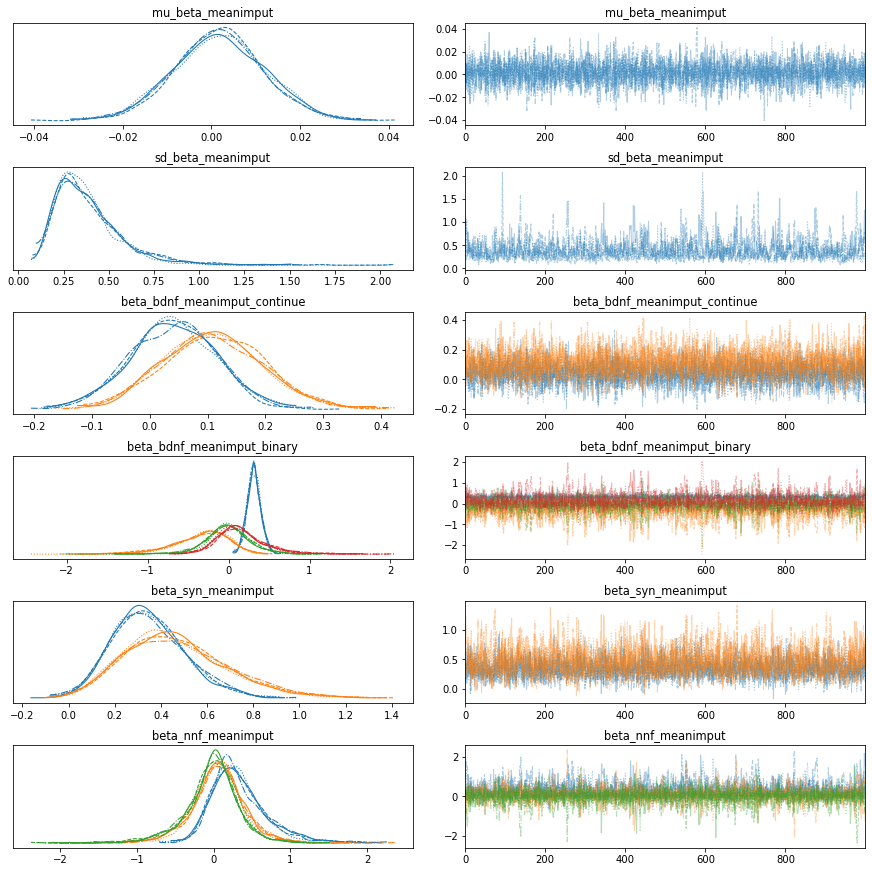

In [29]:
# Check hyperpriors and priors
pm.traceplot(trace_meanimput, var_names=['mu_beta_meanimput', 'sd_beta_meanimput', 'beta_bdnf_meanimput_continue',
                                      'beta_bdnf_meanimput_binary', 'beta_syn_meanimput',
                                         'beta_nnf_meanimput']);

In [ ]:
###ERROR AttributeError: 'InferenceData' object has no attribute 'report'
# Convert to Arviz
idata = az.from_pymc3(trace_meanimput, 
                      posterior_predictive=posterior_all_meanimpute, 
                      prior = priors_all_meanimpute,
                      model = model_meanimput)

### Comparison of models

In [30]:
data_model_meanimpute = az.convert_to_inference_data (trace_meanimput)
data_model_hierar = az.convert_to_inference_data (trace_hierar)

#### Watanabe - Akaike Information Criterion [WAIC]

In [31]:
model_meanimpute_waic = pm.waic(data_model_meanimpute, model_meanimput, var_name='y_obs_bdnf_meanimput')
model_meanimpute_waic.waic

-74.54991869599752

In [32]:
model_hierar_waic = pm.waic(data_model_hierar, model_hierar, var_name='y_obs_bdnf')
model_hierar_waic.waic

nan

In [33]:
model_meanimpute_waic = pm.waic(data_model_meanimpute, model_meanimput, var_name='y_obs_syn_meanimput')
model_meanimpute_waic.waic

-62.115145242523454

In [34]:
model_hierar_waic = pm.waic(data_model_hierar, model_hierar, var_name='y_obs_syn')
model_hierar_waic.waic

-65.07913187245775

In [35]:
model_meanimpute_waic = pm.waic(data_model_meanimpute, model_meanimput, var_name='y_obs_nnf_meanimput')
model_meanimpute_waic.waic

-62.432801204943765

In [36]:
model_hierar_waic = pm.waic(data_model_hierar, model_hierar, var_name='y_obs_nnf')
model_hierar_waic.waic

-63.456166456117984

In [37]:
model_meanimpute_waic = pm.waic(data_model_meanimpute, model_meanimput, var_name='y_obs_dnt_meanimput')
model_meanimpute_waic.waic

-53.341977460624655

In [38]:
model_hierar_waic = pm.waic(data_model_hierar, model_hierar, var_name='y_obs_dnt')
model_hierar_waic.waic

-45.33221352200582

#### Leave-one-out Cross-Validation [LOO]

In [39]:
model_meanimpute_loo = pm.loo(data_model_meanimpute, model_meanimput, var_name='y_obs_bdnf_meanimput')
model_meanimpute_loo.loo

-74.55079583836844

In [40]:
model_hierar_loo = pm.loo(data_model_hierar, model_hierar, var_name='y_obs_bdnf')
model_hierar_loo.loo

nan

In [41]:
model_meanimpute_loo = pm.loo(data_model_meanimpute, model_meanimput, var_name='y_obs_syn_meanimput')
model_meanimpute_loo.loo

-62.11586206111592

In [42]:
model_hierar_loo = pm.loo(data_model_hierar, model_hierar, var_name='y_obs_syn')
model_hierar_loo.loo

-65.29327001039192

In [43]:
model_meanimpute_loo = pm.loo(data_model_meanimpute, model_meanimput, var_name='y_obs_nnf_meanimput')
model_meanimpute_loo.loo

-62.45887300929611

In [44]:
model_hierar_loo = pm.loo(data_model_hierar, model_hierar, var_name='y_obs_nnf')
model_hierar_loo.loo

-63.71211257764889

In [45]:
model_meanimpute_loo = pm.loo(data_model_meanimpute, model_meanimput, var_name='y_obs_dnt_meanimput')
model_meanimpute_loo.loo

-53.38584893487992

In [46]:
model_hierar_loo = pm.loo(data_model_hierar, model_hierar, var_name='y_obs_dnt')
model_hierar_loo.loo

-46.81496403685375

In [ ]:
###BRIER/Ordered BRIER Score?

In [47]:
%load_ext watermark
%watermark -n -u -v -iv -w

theano  1.0.5
arviz   0.10.0
pandas  1.1.1
seaborn 0.11.0
pymc3   3.9.3
numpy   1.19.1
last updated: Mon Sep 28 2020 

CPython 3.8.5
IPython 7.18.1
watermark 2.0.2
